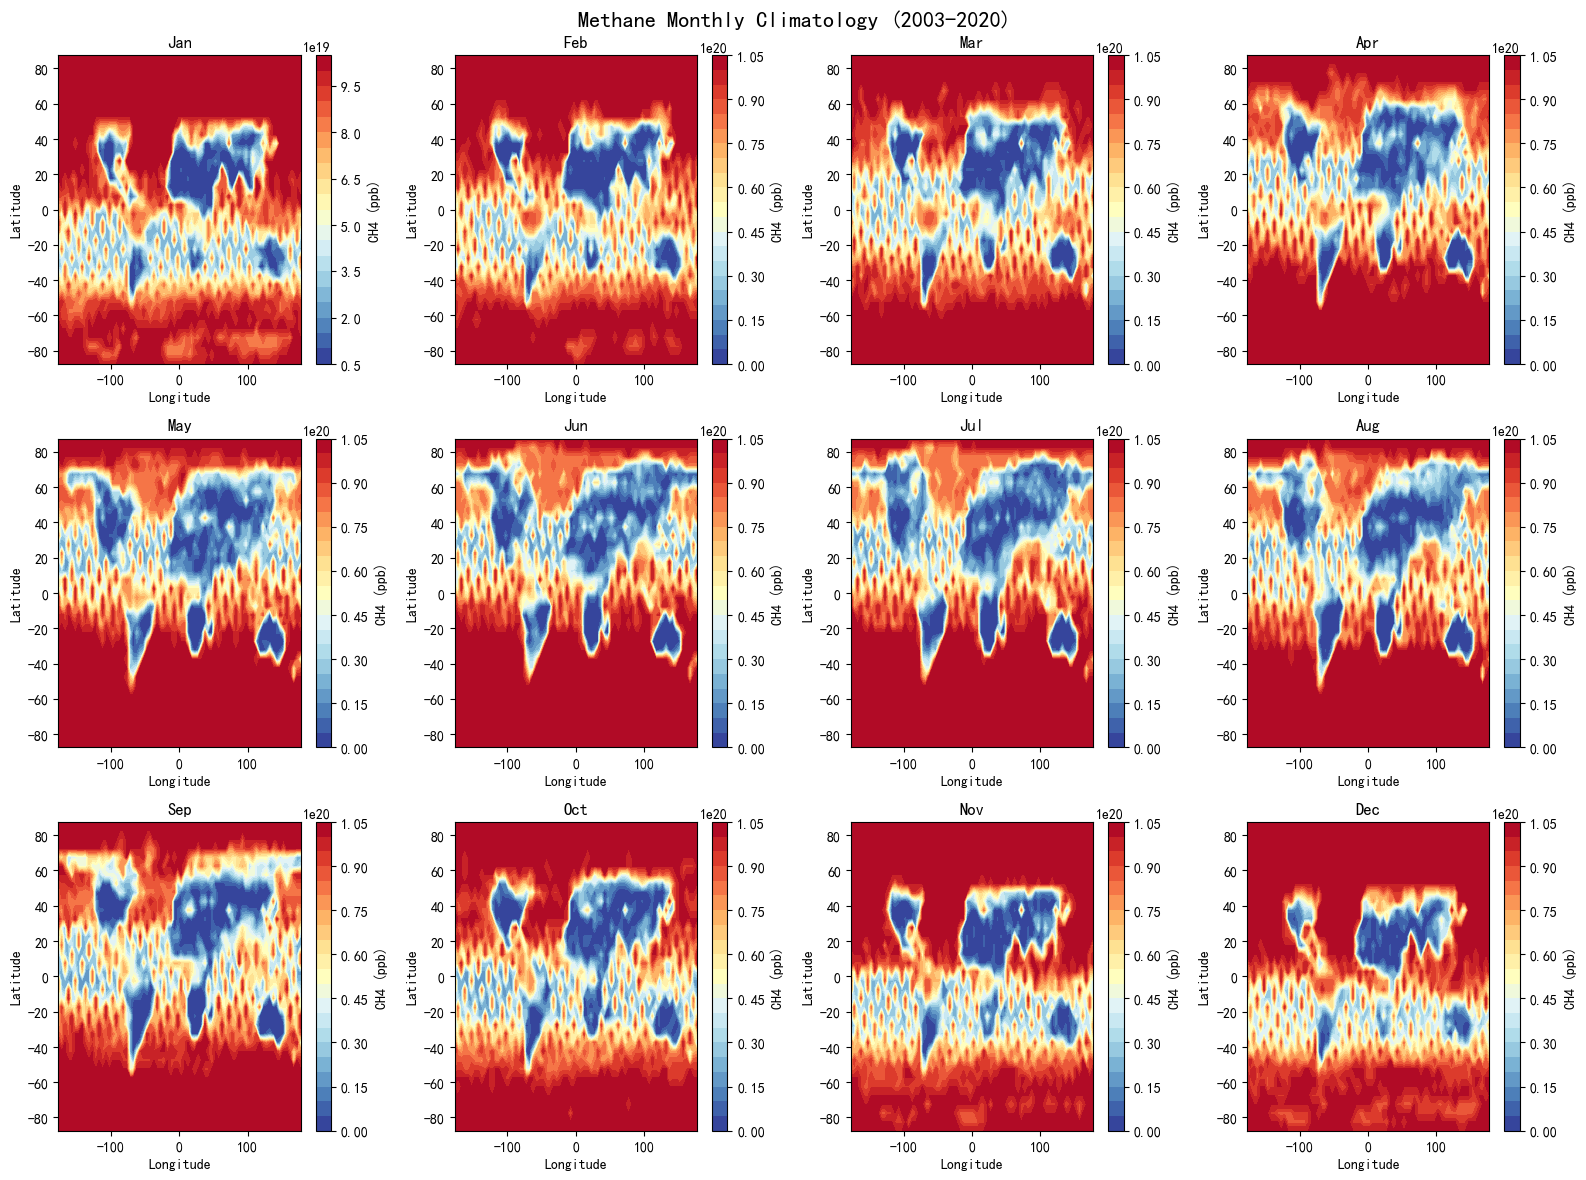

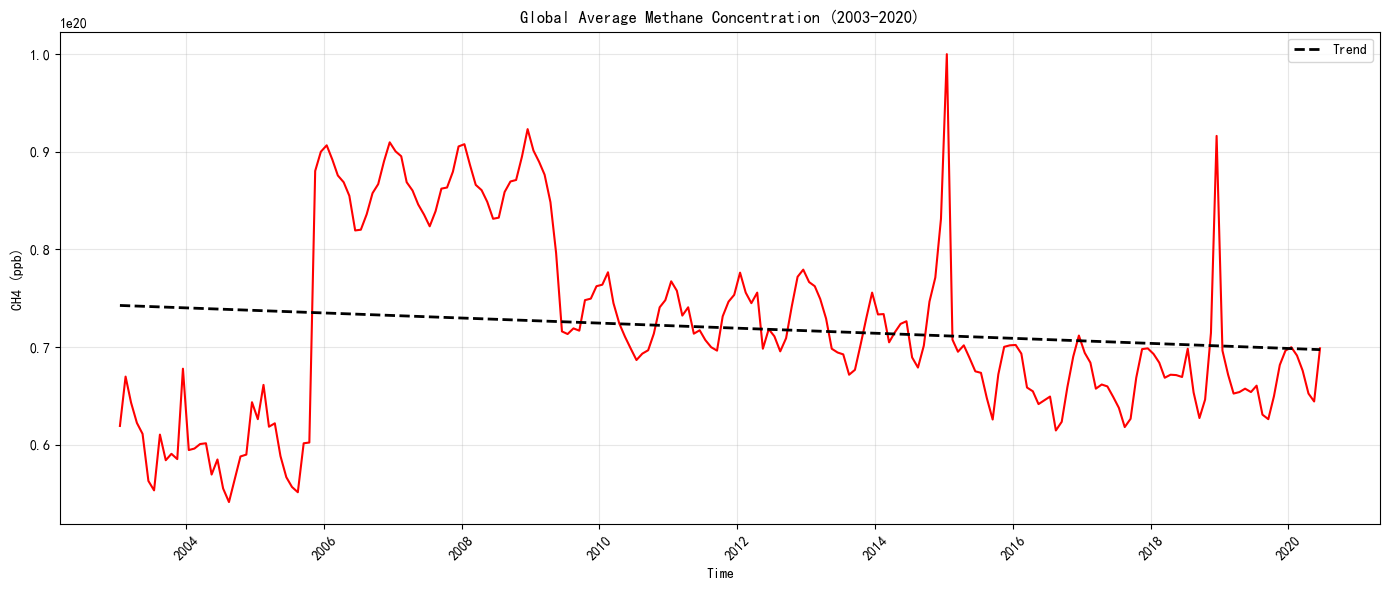

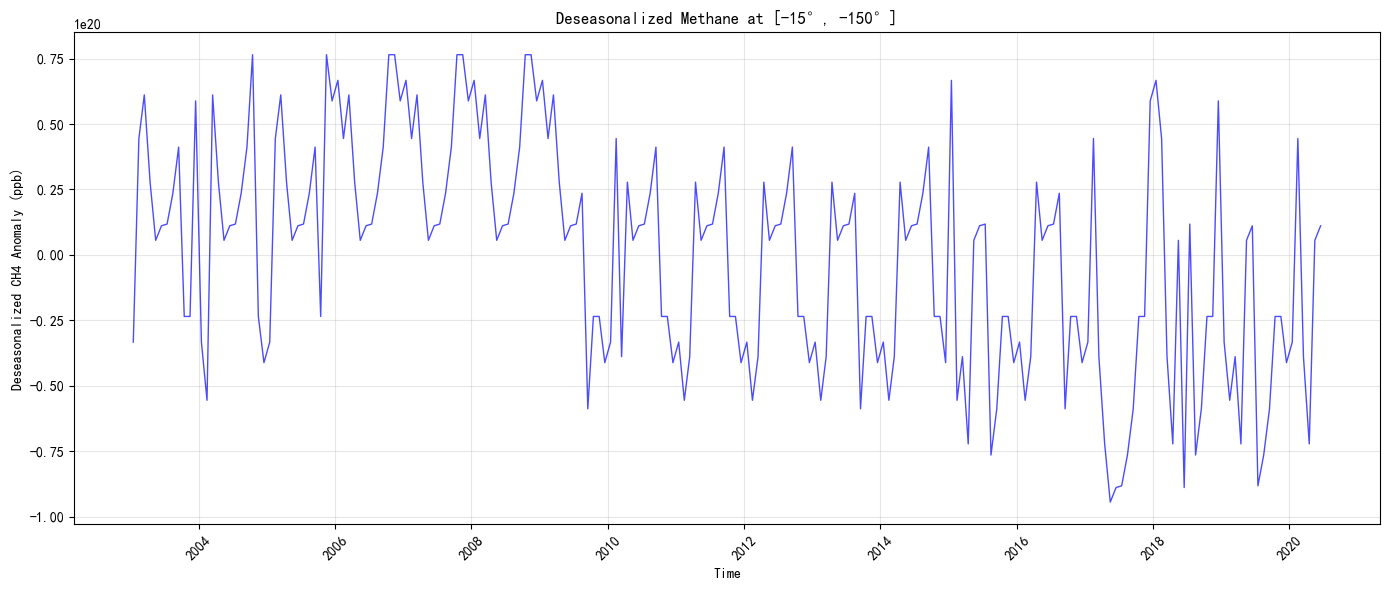

全球甲烷浓度范围: 54128086622203281408.0 - 99999993207994712064.0 ppb
指定点甲烷浓度范围: 0.0 - 100000002004087734272.0 ppb


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import warnings
from datetime import datetime

# 忽略警告
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 文件路径
file_path = r"C:\Users\16963\200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"

# 读取数据
dataset = nc.Dataset(file_path)

# 提取变量
lon = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]
time = dataset.variables['time'][:]
xch4 = dataset.variables['xch4'][:]

# 获取时间信息并转换为标准datetime格式
dates_cftime = nc.num2date(time, units=dataset.variables['time'].units)
# 将cftime对象转换为标准datetime对象
dates = [datetime(d.year, d.month, d.day) for d in dates_cftime]
months = np.array([date.month for date in dates])

# 1.1 计算每月气候态
monthly_climatology = np.zeros((12, len(lat), len(lon)))

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Methane Monthly Climatology (2003-2020)', fontsize=16)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month in range(12):
    month_idx = months == (month + 1)
    month_data = xch4[month_idx, :, :]
    monthly_climatology[month] = np.nanmean(month_data, axis=0)
    
    row = month // 4
    col = month % 4
    ax = axes[row, col]
    
    contour = ax.contourf(lon, lat, monthly_climatology[month], 
                         levels=20, cmap='RdYlBu_r')
    ax.set_title(f'{month_names[month]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(contour, ax=ax, label='CH4 (ppb)')

plt.tight_layout()
plt.show()

# 1.2 计算全球平均时间序列
global_avg = np.nanmean(np.nanmean(xch4, axis=2), axis=1)

plt.figure(figsize=(14, 6))
plt.plot(dates, global_avg, linewidth=1.5, color='red')
plt.title('Global Average Methane Concentration (2003-2020)')
plt.xlabel('Time')
plt.ylabel('CH4 (ppb)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

x_numeric = np.arange(len(global_avg))
coef = np.polyfit(x_numeric, global_avg, 1)
trend_line = np.polyval(coef, x_numeric)
plt.plot(dates, trend_line, 'k--', linewidth=2, label='Trend')

plt.legend()
plt.tight_layout()
plt.show()

# 1.3 计算指定点去季节化序列
target_lat = -15
target_lon = -150

lat_idx = np.argmin(np.abs(lat - target_lat))
lon_idx = np.argmin(np.abs(lon - target_lon))

point_data = xch4[:, lat_idx, lon_idx]

deseasonalized = np.zeros_like(point_data)

for month in range(12):
    month_idx = months == (month + 1)
    month_clim = np.nanmean(point_data[month_idx])
    deseasonalized[month_idx] = point_data[month_idx] - month_clim

plt.figure(figsize=(14, 6))
plt.plot(dates, deseasonalized, linewidth=1, color='blue', alpha=0.7)
plt.title(f'Deseasonalized Methane at [{target_lat}°, {target_lon}°]')
plt.xlabel('Time')
plt.ylabel('Deseasonalized CH4 Anomaly (ppb)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# 打印一些统计信息
dataset.close()

print(f"全球甲烷浓度范围: {np.nanmin(global_avg):.1f} - {np.nanmax(global_avg):.1f} ppb")
print(f"指定点甲烷浓度范围: {np.nanmin(point_data):.1f} - {np.nanmax(point_data):.1f} ppb")

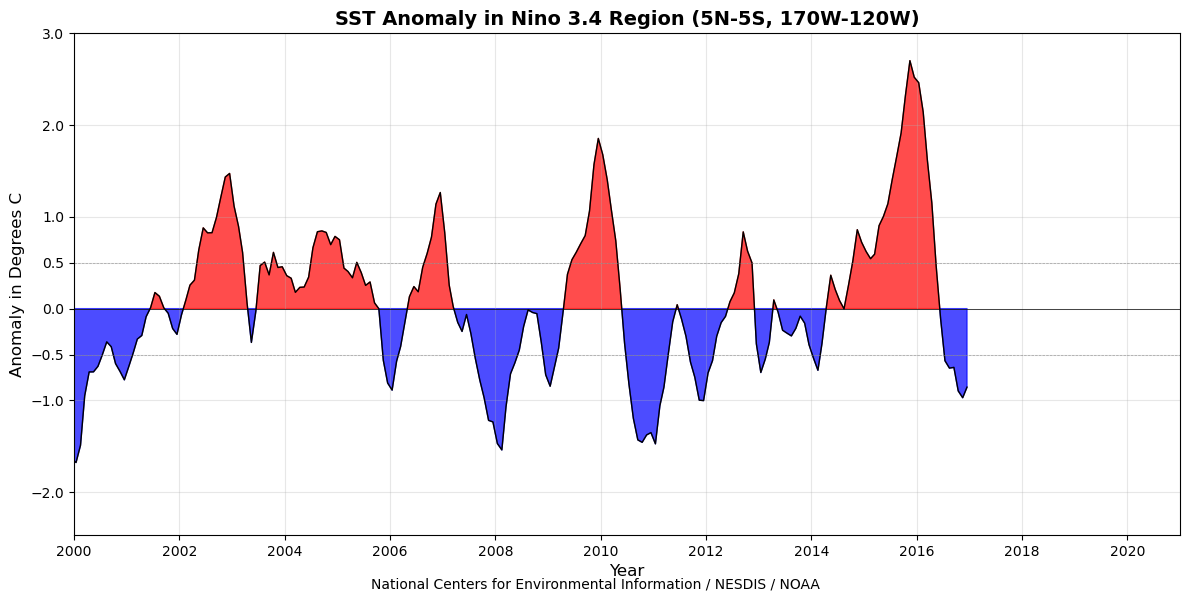

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
from datetime import datetime

# 读取数据
file_path = r"C:\Users\16963\NOAA_NCDC_ERSST_v3b_SST.nc"
dataset = nc.Dataset(file_path)

# 提取变量
sst = dataset.variables['sst'][:]  # 海表温度
lat = dataset.variables['lat'][:]   # 纬度
lon = dataset.variables['lon'][:]   # 经度
time = dataset.variables['time'][:] # 时间

# 获取时间信息
dates = nc.num2date(time, units=dataset.variables['time'].units)
dates_datetime = [datetime(d.year, d.month, d.day) for d in dates]
months = np.array([date.month for date in dates_datetime])
years = np.array([date.year for date in dates_datetime])

# 1.1 计算Niño 3.4区域的月气候态和异常
# Niño 3.4区域: 5N-5S, 120-170W
# 注意: 经度可能是0-360格式，170W=190, 120W=240
lat_idx = np.where((lat >= -5) & (lat <= 5))[0]
lon_idx = np.where((lon >= 190) & (lon <= 240))[0]

# 提取Niño 3.4区域数据
nino34_region = sst[:, lat_idx[0]:lat_idx[-1]+1, lon_idx[0]:lon_idx[-1]+1]
nino34_ts = np.nanmean(np.nanmean(nino34_region, axis=2), axis=1)

# 计算月气候态
monthly_climatology = np.zeros(12)
for month in range(12):
    month_mask = months == (month + 1)
    monthly_climatology[month] = np.nanmean(nino34_ts[month_mask])

# 计算异常值
nino34_anomaly = np.zeros_like(nino34_ts)
for i in range(len(nino34_ts)):
    nino34_anomaly[i] = nino34_ts[i] - monthly_climatology[months[i]-1]

# 1.2 可视化Niño 3.4异常，与参考图相似
plt.figure(figsize=(12, 6))

# 创建时间序列，用于绘图
time_series = dates_datetime

# 绘制异常曲线
plt.plot(time_series, nino34_anomaly, color='black', linewidth=1)

# 填充正异常区域（暖事件）
plt.fill_between(time_series, nino34_anomaly, 0, 
                 where=(nino34_anomaly > 0), 
                 color='red', alpha=0.7, interpolate=True)

# 填充负异常区域（冷事件）
plt.fill_between(time_series, nino34_anomaly, 0, 
                 where=(nino34_anomaly < 0), 
                 color='blue', alpha=0.7, interpolate=True)

# 添加参考线
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.axhline(y=-0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# 设置图形属性
plt.title('SST Anomaly in Nino 3.4 Region (5N-5S, 170W-120W)', fontsize=14, fontweight='bold')
plt.ylabel('Anomaly in Degrees C', fontsize=12)
plt.xlabel('Year', fontsize=12)

# 设置Y轴刻度
plt.yticks([-2, -1, -0.5, 0, 0.5, 1, 2, 3])

# 设置X轴范围（2000-2020）
plt.xlim(datetime(2000, 1, 1), datetime(2020, 12, 31))

# 添加网格
plt.grid(True, alpha=0.3)

# 添加数据来源说明
plt.figtext(0.5, 0.01, 'National Centers for Environmental Information / NESDIS / NOAA', 
           ha='center', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # 为底部文本留出空间
plt.show()

dataset.close()

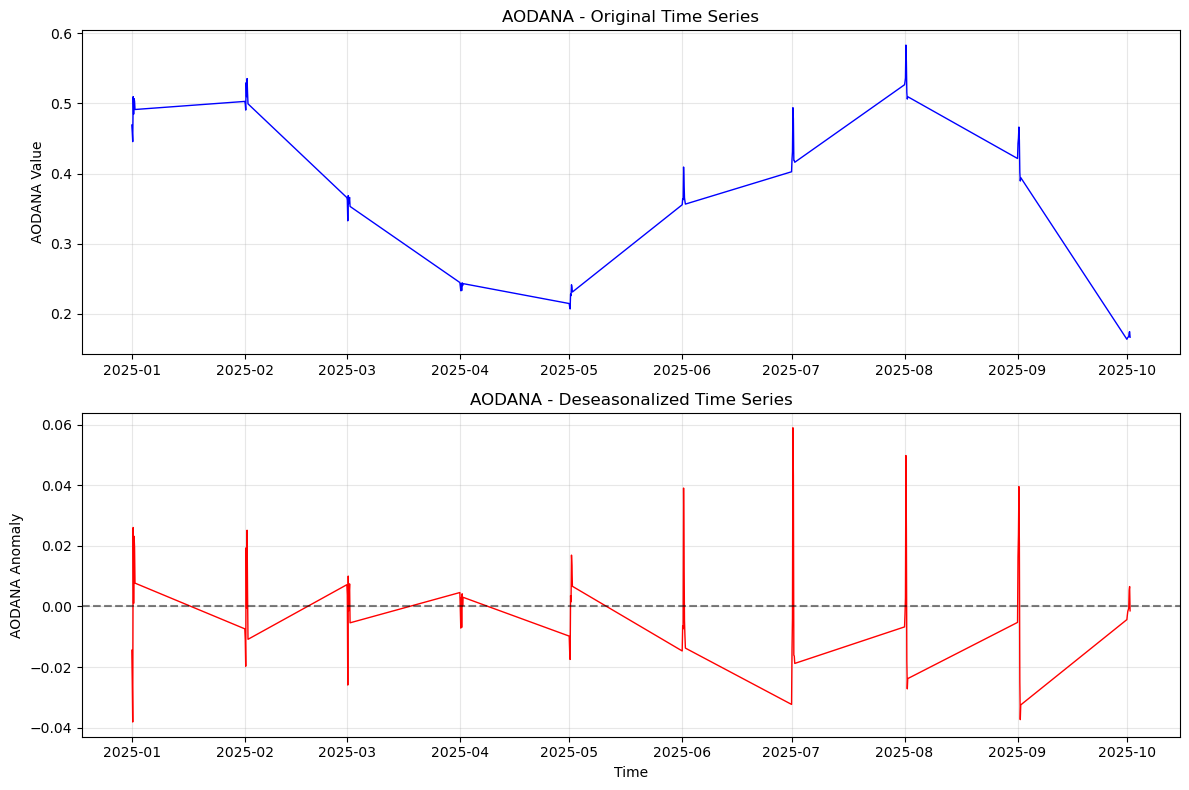

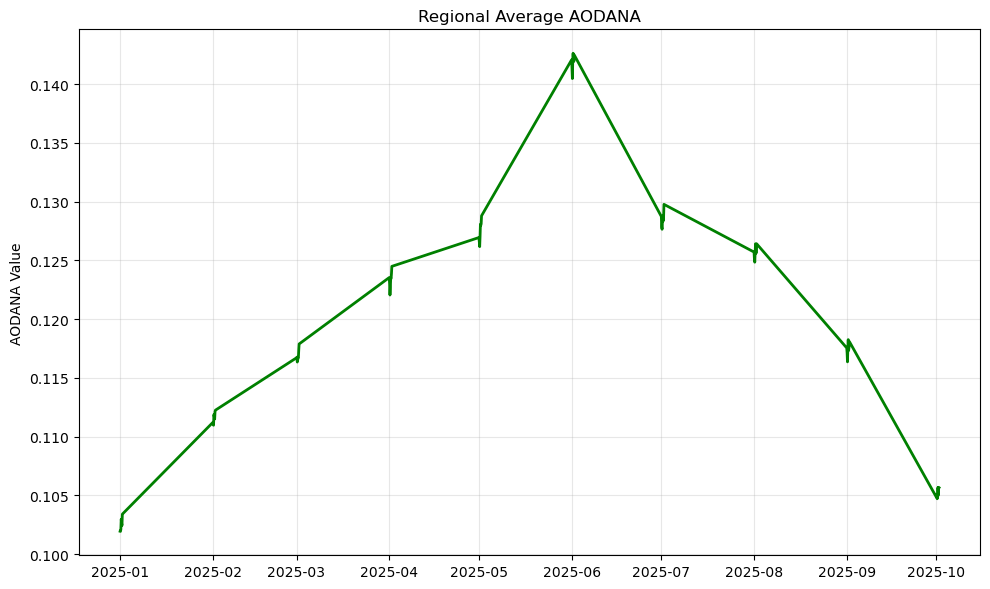

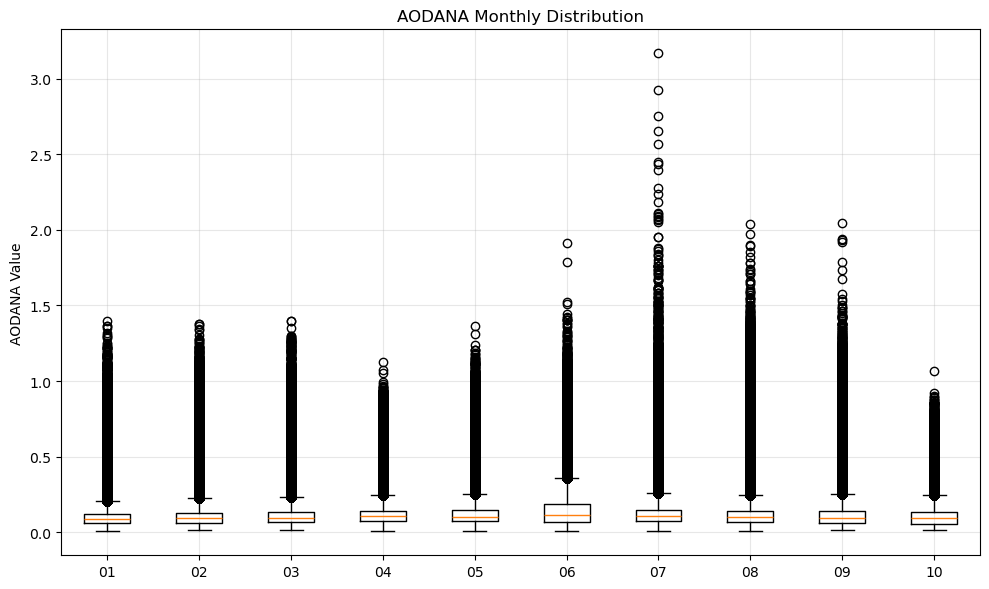

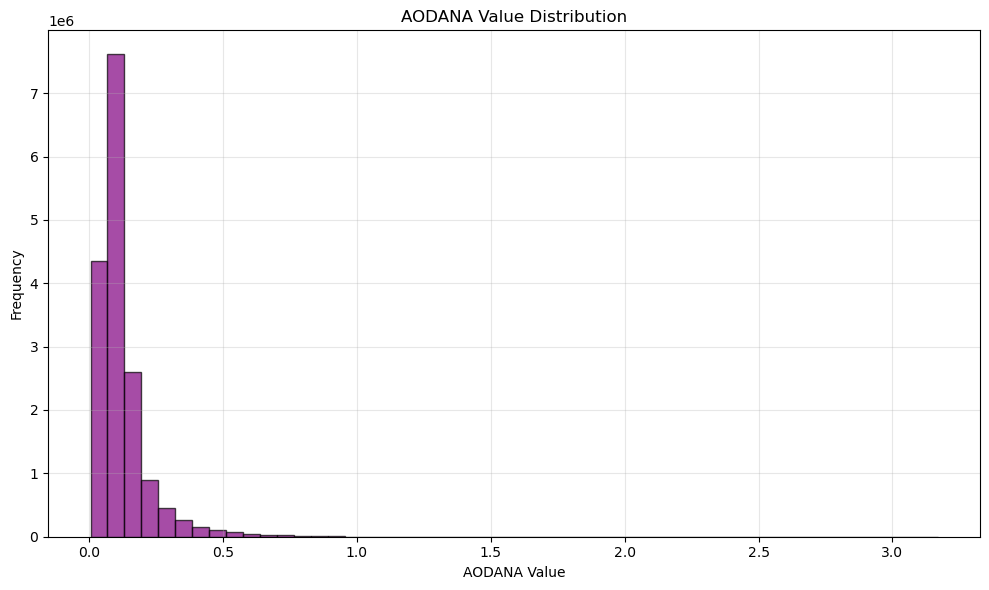

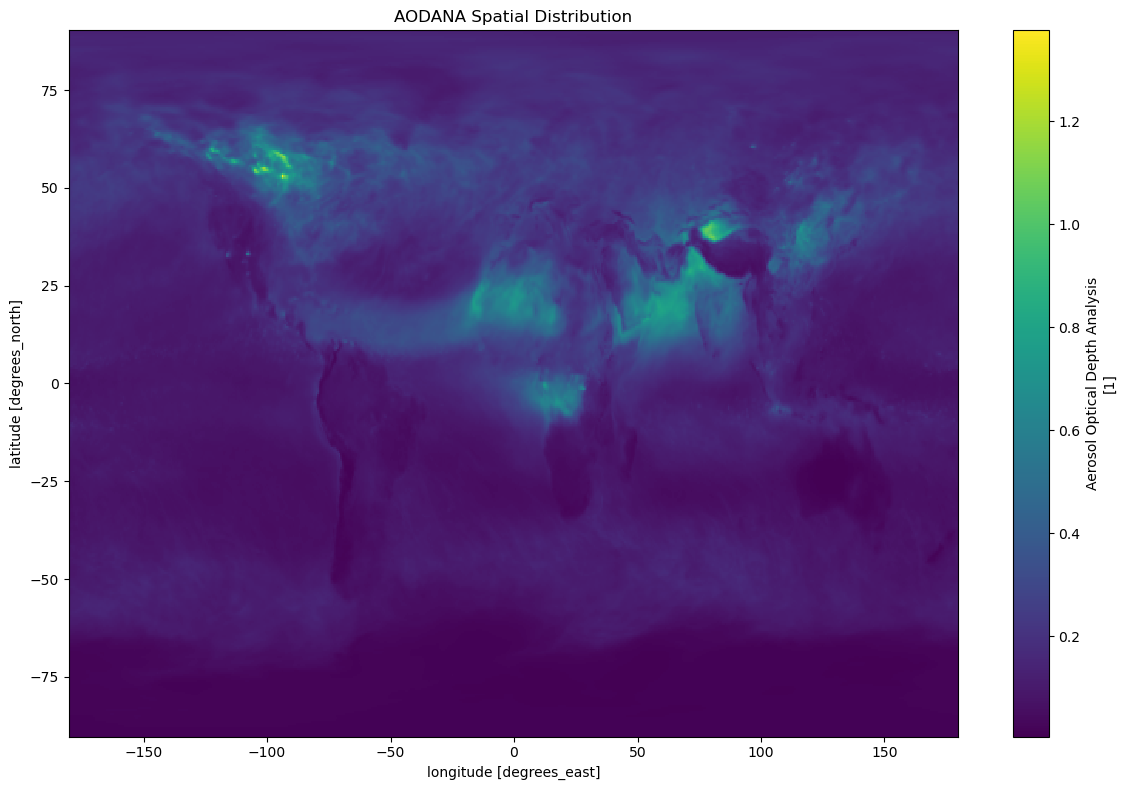

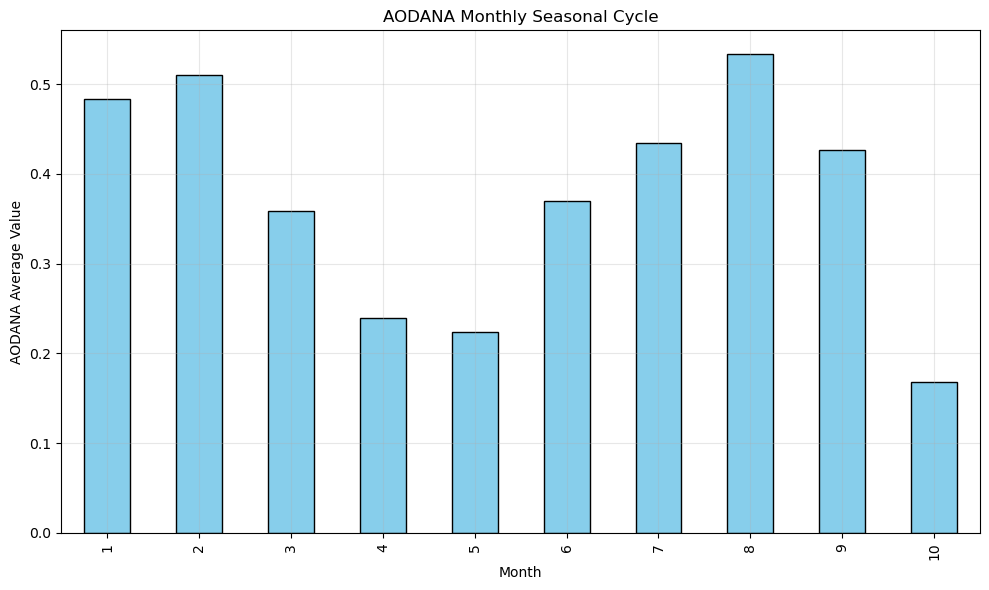

Analysis completed. All charts saved.


In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import stats

# 合并文件
base_path = r"C:\Users\16963"
files = [os.path.join(base_path, f"MERRA2_400.instU_2d_gas_Nx.2025{month:02d}.nc4") 
         for month in range(1, 11)]
files = [f for f in files if os.path.exists(f)]

ds = xr.open_mfdataset(files, combine='by_coords')

# 选择变量
possible_vars = ['CO', 'CO2', 'O3', 'NO2', 'SO2', 'CH4']
target_var = next((var for var in possible_vars if var in ds.variables), None)
if not target_var:
    for var_name, var in ds.variables.items():
        if 'time' in var.dims and len(var.dims) >= 3:
            target_var = var_name
            break
    if not target_var:
        target_var = list(ds.variables.keys())[-1]

# 3.1 去除月季节循环的时间序列
if 'lon' in ds.dims and 'lat' in ds.dims:
    ts_data = ds[target_var].isel(lon=len(ds.lon)//2, lat=len(ds.lat)//2)
else:
    ts_data = ds[target_var].mean(dim=[d for d in ds[target_var].dims if d != 'time'])

ts_series = ts_data.to_pandas()
monthly_cycle = ts_series.groupby(ts_series.index.month).mean()
available_months = ts_series.index.month.unique()

ts_deseasonalized = ts_series.copy()
for month in available_months:
    mask = ts_deseasonalized.index.month == month
    ts_deseasonalized[mask] = ts_deseasonalized[mask] - monthly_cycle[month]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(ts_series.index, ts_series.values, 'b-', linewidth=1)
ax1.set_title(f'{target_var} - Original Time Series')
ax1.set_ylabel(f'{target_var} Value')
ax1.grid(True, alpha=0.3)

ax2.plot(ts_deseasonalized.index, ts_deseasonalized.values, 'r-', linewidth=1)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_title(f'{target_var} - Deseasonalized Time Series')
ax2.set_ylabel(f'{target_var} Anomaly')
ax2.set_xlabel('Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'time_series_deseasonalized.png'), dpi=300, bbox_inches='tight')
plt.show()

# 3.2 5种不同的图表
# 图表1: 区域平均时间序列
global_mean = ds[target_var].mean(dim=[d for d in ds[target_var].dims if d != 'time'])
plt.figure(figsize=(10, 6))
plt.plot(global_mean.time.values, global_mean.values, 'g-', linewidth=2)
plt.title(f'Regional Average {target_var}')
plt.ylabel(f'{target_var} Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'regional_average.png'), dpi=300, bbox_inches='tight')
plt.show()

# 图表2: 月分布箱形图 
monthly_data = []
month_labels = []
for month in range(1, 11):
    try:
        month_data = ds[target_var].sel(time=ds.time.dt.month == month)
        monthly_data.append(month_data.values.flatten())
        month_labels.append(f'{month:02d}')
    except:
        continue

if monthly_data:
    plt.figure(figsize=(10, 6))
    # 使用tick_labels替代labels避免警告
    plt.boxplot(monthly_data, tick_labels=month_labels)
    plt.title(f'{target_var} Monthly Distribution')
    plt.ylabel(f'{target_var} Value')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(base_path, 'monthly_boxplot.png'), dpi=300, bbox_inches='tight')
    plt.show()

# 图表3: 值分布直方图
all_data = ds[target_var].values.flatten()
all_data = all_data[~np.isnan(all_data)]
plt.figure(figsize=(10, 6))
plt.hist(all_data, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title(f'{target_var} Value Distribution')
plt.xlabel(f'{target_var} Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'value_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# 图表4: 空间分布图
if 'lon' in ds.dims and 'lat' in ds.dims:
    time_idx = len(ds.time) // 2
    spatial_data = ds[target_var].isel(time=time_idx)
    plt.figure(figsize=(12, 8))
    spatial_data.plot(cmap='viridis')
    plt.title(f'{target_var} Spatial Distribution')
    plt.tight_layout()
    plt.savefig(os.path.join(base_path, 'spatial_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()

# 图表5: 季节循环可视化
plt.figure(figsize=(10, 6))
monthly_cycle.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f'{target_var} Monthly Seasonal Cycle')
plt.xlabel('Month')
plt.ylabel(f'{target_var} Average Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'seasonal_cycle.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Analysis completed. All charts saved.")